In [3]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *

In [4]:
# no. of stimuli x2 for not-stimuli as well
nf = 2*2
stim = {
    0:"X",
    1:"Y",
    2:"NotX",
    3:"NotY"
}
# variables
dt = 0.1
A = np.arange(0,1,0.2)

In [5]:
#generate a range of s and tau_star
def s_gen(tau_min=1, tau_max=100., buff_max=None, k=20, ntau=40, g=0.0):
    c = (tau_max/tau_min)**(1./(ntau-1))-1
    tau_star = tau_min*(1+c)**np.arange(ntau).astype(float)
    s = 1/tau_star
    return [tau_star, s]
[tau_star, S] = s_gen()

In [6]:
S

array([1.        , 0.88862382, 0.78965229, 0.70170383, 0.62355073,
       0.55410203, 0.49238826, 0.43754794, 0.38881552, 0.34551073,
       0.30702906, 0.27283334, 0.2424462 , 0.21544347, 0.1914482 ,
       0.17012543, 0.15117751, 0.13433993, 0.11937766, 0.10608184,
       0.09426685, 0.08376776, 0.07443803, 0.06614741, 0.05878016,
       0.05223345, 0.04641589, 0.04124626, 0.03665241, 0.03257021,
       0.02894266, 0.02571914, 0.02285464, 0.02030918, 0.01804722,
       0.01603719, 0.01425103, 0.0126638 , 0.01125336, 0.01      ])

In [7]:
def stim_gen(i):
    global nf
    stim_vec = np.zeros(nf)
    if i is not None:
        stim_vec[i] = 1
    return stim_vec

In [8]:
def input_update(a,s,s_idx,fi_IN: None):
    global M
    global F
    global P
    #if fi_IN is not None:
        #print("Inputing stim", stim[fi_IN])
    f_IN = stim_gen(fi_IN)
    #eq 1
    F[s_idx] += -s*F[s_idx] + f_IN
    F[s_idx] = np.where(F[s_idx]<0, 0, F[s_idx])
    #eq 2
    P_IN = np.dot(M[s_idx], f_IN)
    #eq 3
    P[s_idx] +=  s*P[s_idx] + P_IN - P[0]
    P[s_idx] = np.where(P[s_idx]<0, 0, P[s_idx])
    #find stimulis from the past that are still active & update associations
    if fi_IN is not None:
        for past_stim in np.flatnonzero(F[s_idx]):
            #Avoiding self-prediction updates
            if past_stim != fi_IN:
                #eq4 - make sure we're indexing M correctly
                M[s_idx][fi_IN, past_stim] = a * M[s_idx][fi_IN, past_stim] + (1-a) * F[s_idx][past_stim]
def detect_notstim(a,t,s,s_idx,fi_IN:None):
    global M
    global F
    global P
    predicted = np.where(P[s_idx]>=1)[0]
    #iterate through them
    for p in predicted:
        if p == fi_IN:
            print(stim[p], "Observed & Predicted with p=%s! at at s=%s and t=%s"
                  %(P[s_idx][p],s,t))
            P[s_idx][p] = 0
        else:
            P[s_idx][p] = 0
            if p < 2:
                print(stim[p+2], "predicted at s=%s and t=%s" %(s,t))
                #add 2 to get the not-stimuli equivalent
                input_update(a,s,s_idx,fi_IN=p+2)
            else:
                print(stim[p], "predicted at s=%s and t=%s" %(s,t))
                input_update(a,s,s_idx, fi_IN=p)
def timestep_update(a,t,S,fi_IN: None):
    for s_idx, s in enumerate(S):
        input_update(a,s,s_idx,fi_IN)
        detect_notstim(a,t,s,s_idx,fi_IN) 

In [209]:
#alter this for different stimuli presentation at different times
t_max = 15
T = np.arange(0,t_max, dt)
#pick an s value to track
s_track = [3,7,19,27]
f = [[0,1],[1,3],[0,7],[0,t_max+0.1]]
P_tracker = np.ndarray(shape=(len(T), len(s_track), nf), dtype=float)
F_tracker = np.ndarray(shape=(len(T), len(s_track), nf), dtype=float)

In [210]:
M = np.zeros([len(S), nf, nf])
F = np.zeros([len(S), nf])
P = np.zeros([len(S), nf])
for t in T:
    if f[0][1] == t:
        fi_IN = f[0][0]
        timestep_update(a,t,S,fi_IN=fi_IN)
        f.pop(0)
    else:
        timestep_update(a,t,S,fi_IN=None)
    t_idx = int(t*10)
    for s_idx, s in enumerate(s_track):
        P_tracker[t_idx,s_idx] = P[s]
        F_tracker[t_idx,s_idx] = F[s]

NotY predicted at s=0.24244620170823306 and t=10.3
NotY predicted at s=0.3455107294592222 and t=10.4
NotY predicted at s=0.3070290629757852 and t=10.4
NotY predicted at s=0.27283333764867707 and t=10.4
NotY predicted at s=0.21544346900318861 and t=10.4
NotY predicted at s=0.19144819761699602 and t=10.4
NotY predicted at s=0.1701254279852591 and t=10.4
NotY predicted at s=0.3888155180308091 and t=10.5
NotY predicted at s=0.1511775070615664 and t=10.5
NotY predicted at s=0.1343399332598902 and t=10.600000000000001
NotY predicted at s=0.4375479375074187 and t=10.700000000000001
NotY predicted at s=0.11937766417144383 and t=10.700000000000001
NotY predicted at s=0.49238826317067413 and t=10.8
NotY predicted at s=0.10608183551394501 and t=10.9
NotY predicted at s=0.09426684551178867 and t=11.0
NotY predicted at s=0.5541020330009494 and t=11.100000000000001
NotY predicted at s=0.08376776400682932 and t=11.200000000000001
NotY predicted at s=0.6235507341273916 and t=11.4
NotY predicted at s=0

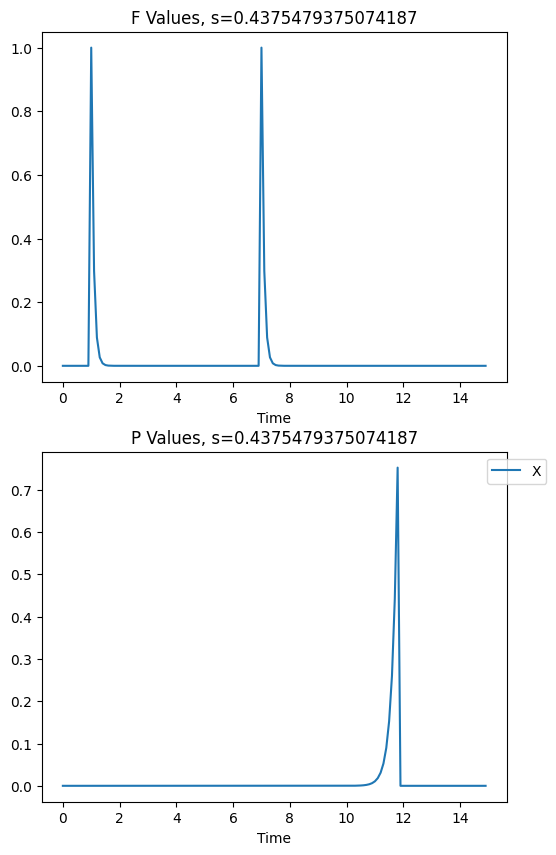

In [211]:
#plot individual s value
fig = plt.figure(figsize = (6,10))
ax = fig.subplots(2,1)
ax[0].plot(T, F_tracker[:,0,0])
ax[0].set_title("F Values, s=%s" %(S[s_track[1]]))
ax[0].set_xlabel("Time")
#ax[0].legend(['X', 'Y','Not X', 'Not Y'])

ax[1].plot(T, P_tracker[:,0,1])
ax[1].set_title("P Values, s=%s" %(S[s_track[1]]))
ax[1].set_xlabel("Time")
ax[1].legend(['X', 'Y','Not-X (X predicted, not observed)', 'Not Y (Y predicted, not observed)']
             ,bbox_to_anchor=(1.1, 1))

Text(11, 3.4, 'Y Predictions')

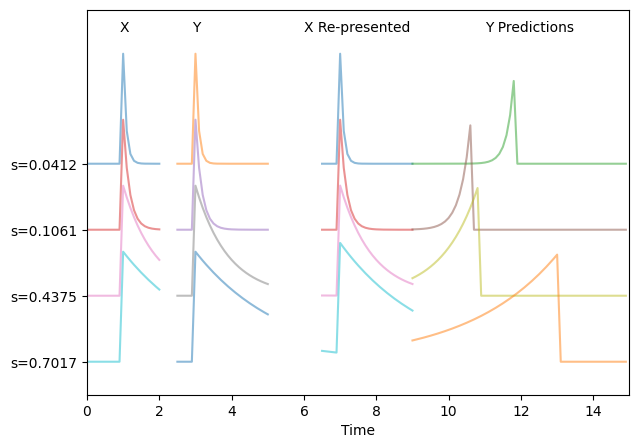

In [217]:
fig2,ax2 = plt.subplots(figsize = (7,5))
for idx in range(len(s_track)):
    plot_inc = 0.6 * (3.5-idx)
    #F_masked = F_tracker[:,idx,0]+plot_inc
    F_X_masked = np.ma.masked_where(((T>2)&(T<6.5))|(T>9.0),(F_tracker[:,idx,0]+plot_inc))
    F_Y_masked = np.ma.masked_where((T<2.5)|(T>5.0),(F_tracker[:,idx,1]+plot_inc))
    P_masked = np.ma.masked_where((T<9.0), (P_tracker[:,idx,1]+plot_inc))
    #P_masked = P_tracker[:,idx,1]+plot_inc
    ax2.plot(T,F_X_masked, alpha=0.5)
    ax2.plot(T,F_Y_masked, alpha=0.5)
    ax2.plot(T,P_masked,alpha=0.5)
ax2.set_ylim(0, 3.5)
ax2.set_xlim(0, 15.0)
ax2.set_xlabel('Time')
ax2.set_yticks([0.3, 0.9, 1.5, 2.1],
               ['s=%s' %(S[s_track[0]].round(4)),
                's=%s' %(S[s_track[1]].round(4)),
                's=%s' %(S[s_track[2]].round(4)),
                's=%s' %(S[s_track[3]].round(4))
               ])
ax2.text(0.9,3.4, "X", verticalalignment='top')
ax2.text(2.9,3.4, "Y", verticalalignment='top')
ax2.text(6,3.4, "X Re-presented", verticalalignment='top')
ax2.text(11,3.4, "Y Predictions", verticalalignment='top')

In [ ]:
#plot using imshow
#fig = plt.figure(figsize = (5,10))
#ax = fig.subplots(2,1)
#ax[0].imshow(F_tracker, aspect='auto')
#ax[0].set_title("F Values, s=%s" %(S[s_track]))
#ax[0].set_ylabel("Time")
#ax[0].set_xticks(np.arange(4),['X', 'Y','Not X', 'Not Y'])
#ax[1].imshow(P_tracker, aspect='auto')
#ax[1].set_title("P Values, s=%s" %(S[s_track]))
#ax[1].set_ylabel("Time")
#ax[1].set_xticks(np.arange(4),['X', 'Y','Not X', 'Not Y'])
#ax[2].imshow(P_max, aspect='auto')
#ax[2].set_title("P Values, s=%s" %(S[-1]))
#ax[2].set_ylabel("Time")
#ax[2].set_xticks(np.arange(4),['X', 'Y','Not X', 'Not Y'])

In [ ]:
#plot tracked variables through time - doesn't work yet
#x = np.arange(nf)
#fig = plt.figure()
#ax = fig.subplots(3,1)
#i = 0
#F_plot = ax[0].scatter(x, F_tracker[i])
#P_plot = ax[2].scatter(x, P_tracker[i])
#M_plot = ax[1].pcolormesh(M_tracker[i])

#def update(i=0.0):
#    idx = int(i*10)
#    F_plot.set_offsets(np.c_[x,F_tracker[idx]])
#    P_plot.set_offsets(np.c_[x,P_tracker[idx]])
#    M_plot.set_array(M_tracker[idx])
#    #scatter.set_ydata(Tracker[idx])
#    fig.canvas.draw_idle()

#interact(update, i = (0.0,t_max,dt));